### 1. Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn.pipeline import Pipeline

**Read csv**

In [3]:
X_train = pd.read_csv('../data/processed/X_train.zip')
X_val = pd.read_csv('../data/processed/X_val.zip')
X_test = pd.read_csv('../data/processed/X_test.zip')
y_train = pd.read_csv('../data/processed/y_train.zip')
y_val = pd.read_csv('../data/processed/y_val.zip')
y_test = pd.read_csv('../data/processed/y_test.zip')

#Pipieline
preprocessor = load('../models/pipe.pkl')

In [4]:
#Dimension
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

X_train: (2520168, 16)
X_val: (630043, 16)
X_test: (787553, 16)
y_train: (2520168, 1)
y_val: (630043, 1)
y_test: (787553, 1)


In [5]:
#Path from above unzipping file
extract_path = 'C:\\Users\\ting_\\OneDrive - UTS\\2024 SPR SESSION\\36120 Advanced MLAA\\Assignments\\AT3 Data Product\\data\\itineraries_csv'
import os

### 2. XGBoost Regressor Model - default

In [6]:
import xgboost as xgb

#### [2.1] Apply pipeline

In [7]:
xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', xgb.XGBRegressor(random_state=42))
    ]
).set_output(transform="pandas")

#### [2.2] Fit the model

In [8]:
y_train = y_train.values.ravel()

In [9]:
xgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['totalTravelDistance',
                                                   'date_diff', 'day',
                                                   'day_of_week',
                                                   'week_of_year', 'month',
                                                   'n_stops', 'hour',
                                                   'minute']),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

#### [2.3] Make predictions

In [10]:
y_train_pred = xgb_pipe.predict(X_train)
y_val_pred = xgb_pipe.predict(X_val)

#### [2.4] Evaluation Metrics - RMSE

In [11]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae

In [12]:
print("RMSE_train:", f'{rmse(y_train_pred, y_train):.4f}')
print("RMSE_val:", f'{rmse(y_val_pred, y_val):.4f}')
print("MAE_train:", f'{mae(y_train_pred, y_train):.4f}')
print("MAE_val:", f'{mae(y_val_pred, y_val):.4f}')

RMSE_train: 102.3944
RMSE_val: 103.6226
MAE_train: 65.9239
MAE_val: 66.2584


### 3. XGBoost Regressor Model - hyperparameter tuning with hyperopt

#### [3.1] Import parameters from hyperopt

In [13]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
rstate = np.random.default_rng(42)

#### [3.2] Define Pipeline

In [14]:
xgb_pipe2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
         ('xgb', xgb.XGBRegressor())
    ]
)

#### [3.3] Define search space

In [15]:
space = {
    'xgb__max_depth' : hp.choice('xgb__max_depth', range(3, 15, 1)),
    'xgb__min_child_weight' : hp.choice('xgb__min_child_weight', range(3, 15, 1)),
    'xgb__learning_rate' : hp.quniform('xgb__learning_rate', 0.01, 0.4, 0.05),
    'xgb__subsample' : hp.quniform('xgb__subsample', 0.6, 1, 0.05),
    'xgb__colsample_bytree' : hp.quniform('xgb__colsample_bytree', 0.3, 1, 0.05)
}

#### [3.4] Define objective

In [16]:
def objective(space):
    from sklearn.base import clone
    xgboostpipe = clone(xgb_pipe2)
    xgboostpipe.set_params(**{
                'xgb__max_depth': int(space['xgb__max_depth']),
                'xgb__learning_rate' : space['xgb__learning_rate'],
                'xgb__min_child_weight' : space['xgb__min_child_weight'],
                'xgb__subsample' : space['xgb__subsample'],
                'xgb__colsample_bytree' : space['xgb__colsample_bytree']
    })

    xgboostpipe.fit(X_train,y_train)
    y_val_pred = xgboostpipe.predict(X_val)
    rmse_val = rmse(y_val_pred, y_val)
    
    return {
        "loss" : rmse_val,
        'status': STATUS_OK
    }

trials=Trials()

#### [3.5] Launch hyperopt search and find the best set of hyperparameters

In [17]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    rstate=rstate,
    trials=trials
)

100%|█████| 10/10 [09:47<00:00, 58.76s/trial, best loss: 79.74705265657238]


In [18]:
print("Best: ", best)

Best:  {'xgb__colsample_bytree': np.float64(0.55), 'xgb__learning_rate': np.float64(0.30000000000000004), 'xgb__max_depth': np.int64(9), 'xgb__min_child_weight': np.int64(9), 'xgb__subsample': np.float64(0.65)}


#### [3.6] Instantiate model with best set of hyperparameters

In [19]:
xgb_pipe3 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
         ('xgb', xgb.XGBRegressor(
                    max_depth = best['xgb__max_depth'],
                    learning_rate = best['xgb__learning_rate'],
                    min_child_weight = best['xgb__min_child_weight'],
                    subsample = best['xgb__subsample'],
                    colsample_bytree = best['xgb__colsample_bytree']
         ))
    ]
).set_output(transform='pandas')

#### [3.7] Fit the model and make prediction

In [20]:
xgb_pipe3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['totalTravelDistance',
                                                   'date_diff', 'day',
                                                   'day_of_week',
                                                   'week_of_year', 'month',
                                                   'n_stops', 'hour',
                                                   'minute']),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                              interaction_constraints=None,
                              learning_rate=np.float64(0.30000000000000004),
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=np.int64(9), max_leaves=None,
                              min_child_weight=np.int64(9), missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [21]:
y_train_pred3 = xgb_pipe3.predict(X_train)
y_val_pred3 = xgb_pipe3.predict(X_val)

#### [3.8] Evaluation Metrics - RMSE

In [22]:
print("RMSE_train:", f'{rmse(y_train_pred3, y_train):.4f}')
print("RMSE_val:", f'{rmse(y_val_pred3, y_val):.4f}')
print("MAE_train:", f'{mae(y_train_pred3, y_train):.4f}')
print("MAE_val:", f'{mae(y_val_pred3, y_val):.4f}')

RMSE_train: 89.1166
RMSE_val: 91.5335
MAE_train: 56.3725
MAE_val: 57.3210


In [23]:
y_test_pred = xgb_pipe3.predict(X_test)
print("RMSE_test:", f'{rmse(y_test_pred, y_test):.4f}')
print("MAE_test:", f'{mae(y_test_pred, y_test):.4f}')

RMSE_test: 90.7533
MAE_test: 57.1171


#### Save the model

In [24]:
from joblib import dump
dump(xgb_pipe3,  '../models/xgb.pkl')

['../models/xgb.pkl']

### 4. Variable importance by permutation

In [30]:
from sklearn.inspection import permutation_importance

In [31]:
r = permutation_importance(
    xgb_pipe3, X_train, y_train,
    random_state=8
)

In [32]:
preprocess_pipe = xgb_pipe3[:-1].fit(X_train,y_train)
X_train_trans = preprocess_pipe.transform(X_train)

In [33]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train_trans.columns[i]}: {r.importances_mean[i]:.4f}")

num_cols__day: 0.6768
num_cols__date_diff: 0.3021
num_cols__totalTravelDistance: 0.2889
cat_cols__Cabin_Leg2_coach: 0.1873
cat_cols__startingAirport_LAX: 0.1765
num_cols__month: 0.1279
cat_cols__startingAirport_LGA: 0.1063
num_cols__n_stops: 0.0923
cat_cols__startingAirport_MIA: 0.0790
num_cols__day_of_week: 0.0722
num_cols__week_of_year: 0.0565
cat_cols__isWeekend_True: 0.0487
cat_cols__Cabin_Leg2_first: 0.0259
num_cols__hour: 0.0134
num_cols__minute: 0.0014
cat_cols__Cabin_Leg2_no_stop: 0.0003


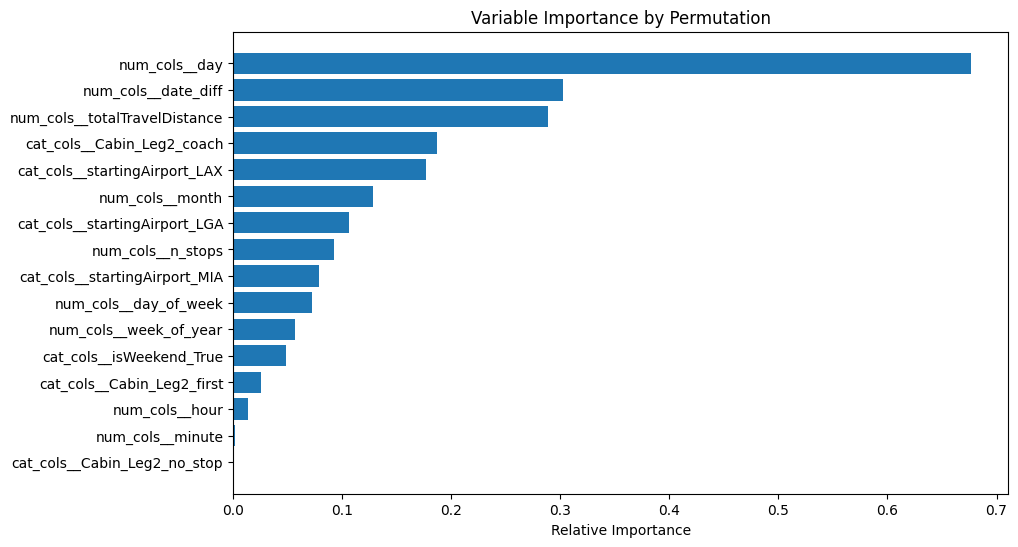

In [34]:
importances = r.importances_mean
idx = np.argsort(importances)[::-1]
importances = importances[idx]
feature_names = X_train_trans.columns
feature_names = feature_names[idx]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Relative Importance")
plt.title("Variable Importance by Permutation")
plt.gca().invert_yaxis()
plt.savefig('../reports/figures/perm_imp.png', bbox_inches='tight')
plt.show()